In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd

# Import the project utils
import sys
sys.path.insert(0, '../utilities/')
import mwc_induction_utils as mwc
import sortseq_utils as sortseq
from sequence_logo import *
mwc.set_plotting_style()

colors=sns.light_palette(color='#b73826', n_colors=8)
colors_alt=sns.color_palette('Blues')
sns.set_palette(colors)

colors_qual=sns.color_palette(
    ['#55934d', '#b73720', '#4976b7', '#dda83d', '#985c9b', '#905426'])

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Figure 6

Here we show how changing the context of a binding site may (or may not) alter sequence specificity. We compare two binding site contexts (i.e. the location of a binding site within a promoter) for three different transcription factors. We quantify the changes in sequence specificity using the Pearson's correlation coefficient. 

In [3]:
# Load matrices for all binding sites

# Start with XylR
xylR_left = []
xylR_right = []

for i in range(1, 4):
    # Load array
    array = np.loadtxt('../../data/models/splits/xylR_left_split%i' % i, skiprows=7, usecols=(1,2,3,4))
    
    # Fix each matrix so that the lowest energy sequence is fixed at 0
    minvals = []
    for n, row in enumerate(array):
        minval = min(row)
        for m, val in enumerate(row):
            array[n][m] = val - minval
    
    # Infer a hypothetical scaling factor
    array_vals = np.array([val for val in array.ravel() if val != 0])
    scaling_factor = 2.5/np.mean(array_vals)
    scaled_array = array * scaling_factor
    
    xylR_left.append(scaled_array)
    
for i in range(1, 4):
    # Load array
    array = -np.loadtxt('../../data/models/splits/xylR_right_split%i' % i, skiprows=8, usecols=(1,2,3,4))
    
    # Fix each matrix so that the lowest energy sequence is fixed at 0
    minvals = []
    for a, row in enumerate(array):
        minval = min(row)
        for b, val in enumerate(row):
            array[a][b] = val - minval
    
    # Infer a hypothetical scaling factor
    array_vals = np.array([val for val in array.ravel() if val != 0])
    scaling_factor = 2.5/np.mean(array_vals)
    scaled_array = array * scaling_factor
        
    xylR_right.append(scaled_array)

In [4]:
# Move on to PurR and LacI

purR_mid_raw = np.load('../../data/models/splits/purRwtadenine_v2forT.npy')
purR_down_raw = np.load('../../data/models/splits/purRsimplerepadenineforT.npy')
O1_1027_raw = np.load('../../data/models/splits/lacThermoforTO1.npy')
O1_up_raw = np.load('../../data/models/splits/lacupstreamforT.npy')

raw_list = [purR_mid_raw, purR_down_raw, O1_1027_raw, O1_up_raw]

purR_mid = np.zeros(np.shape(purR_mid_raw))
purR_down = np.zeros(np.shape(purR_down_raw))
O1_1027 = np.zeros(np.shape(O1_1027_raw))
O1_up = np.zeros(np.shape(O1_up_raw))

fixed_list= [purR_mid, purR_down, O1_1027, O1_up]

for i in range(len(raw_list)):
    for j in range(3):
        array = raw_list[i][j]
        minvals = []
        for a, row in enumerate(array):
            minval = min(row)
            for b, val in enumerate(row):
                array[a][b] = val - minval

        # Infer a hypothetical scaling factor
        array_vals = np.array([val for val in array.ravel() if val != 0])
        scaling_factor = 2.5/np.mean(array_vals)
        scaled_array = array * scaling_factor

        fixed_list[i][j] = scaled_array

In [5]:
# Define function for determining Pearson's corellation coefficient. 

def pearsons(X, Y):
    cov = 0
    for i in range(len(X)):
        cov += (X[i] - np.mean(X)) * (Y[i] - np.mean(Y))/len(X)
    return cov/(np.std(X) * np.std(Y))

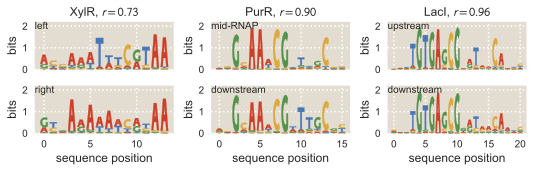

In [6]:
# Scale arrays so that average mutation costs 2.5 kBT and plot sequence logos

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(7.5, 2.5))
a = np.ravel(ax)
names_list = ['left', 'mid-RNAP', 'upstream', 'right', 'downstream', 'downstream']
array_list = [np.mean(xylR_left, axis=0), np.mean(purR_mid, axis=0), np.mean(O1_up, axis=0),\
             np.mean(xylR_right, axis=0), np.mean(purR_down, axis=0), np.mean(O1_1027, axis=0)]

for i, array in enumerate(array_list):
    seq_logo(array, ax=a[i], colors=['#ce3e27', '#dda83d', '#55934d', '#4976b7'])
    a[i].text(0, 2.2, names_list[i], va='top', fontsize=10)
    a[i].set_ylim(0,2.2)
    a[i].set_ylabel('bits')
    a[i].set_xticks([1, 6, 11, 16])
    a[i].set_yticks([0, 1, 2])
    a[i].set_xticklabels(['', '', '', '', ''])

a[0].set_title(r'XylR, $r = %0.2f$' % pearsons(np.mean(xylR_left, axis=0).ravel(),\
                                              np.mean(xylR_right, axis=0).ravel()))
a[0].set_xlim(0,15)
a[3].set_xlim(0,15)
a[3].set_xticklabels([0, 5, 10])
a[3].set_xlabel('sequence position')

a[1].set_title('PurR, $r = %0.2f$' % pearsons(np.mean(purR_mid, axis=0).ravel(),\
                                              np.mean(purR_down, axis=0).ravel()))
a[1].set_xlim(0,17)
a[4].set_xlim(0,17)
a[4].set_xticklabels([0, 5, 10, 15])
a[4].set_xlabel('sequence position')

a[2].set_title('LacI, $r = %0.2f$' % pearsons(np.mean(O1_up, axis=0).ravel(),\
                                              np.mean(O1_1027, axis=0).ravel()))
a[2].set_xlim(0,22)
a[2].set_xticks([1, 6, 11, 16, 21])
a[5].set_xlim(0,22)
a[5].set_xticks([1, 6, 11, 16, 21])
a[5].set_xticklabels([0, 5, 10, 15, 20])
a[5].set_xlabel('sequence position')

plt.tight_layout()
plt.savefig('fig6.pdf', bbox_inches='tight')

In [18]:
# Report on probabilities for XylR
left_probs = []
right_probs = []
for i in range(3):
    left_probs.append(prob_array(xylR_left[i]))
    right_probs.append(prob_array(xylR_right[i]))

In [24]:
probs_6 = []
probs_7 = []
probs_8 = []
# Left
for i in range(3):
    probs_6.append(left_probs[i][6][3])
    probs_7.append(left_probs[i][7][3])
    probs_8.append(left_probs[i][8][3])
print('left prob pos 6: %0.2f +/- %0.2f' % (np.mean(np.array(probs_6)), np.std(np.array(probs_6))))
print('left prob pos 7: %0.2f +/- %0.2f' % (np.mean(np.array(probs_7)), np.std(np.array(probs_7))))
print('left prob pos 8: %0.2f +/- %0.2f' % (np.mean(np.array(probs_8)), np.std(np.array(probs_8))))

probs_6 = []
probs_7 = []
probs_8 = []
# Right
for i in range(3):
    probs_6.append(right_probs[i][6][0])
    probs_7.append(right_probs[i][7][0])
    probs_8.append(right_probs[i][8][0])
print('right prob pos 6: %0.2f +/- %0.2f' % (np.mean(np.array(probs_6)), np.std(np.array(probs_6))))
print('right prob pos 7: %0.2f +/- %0.2f' % (np.mean(np.array(probs_7)), np.std(np.array(probs_7))))
print('right prob pos 8: %0.2f +/- %0.2f' % (np.mean(np.array(probs_8)), np.std(np.array(probs_8))))

left prob pos 6: 0.89 +/- 0.03
left prob pos 7: 0.54 +/- 0.01
left prob pos 8: 0.65 +/- 0.03
right prob pos 6: 0.58 +/- 0.01
right prob pos 7: 0.79 +/- 0.01
right prob pos 8: 0.47 +/- 0.01


In [17]:
# Load p vals for xylR 
xylR_pvals = np.load('../../data/models/splits/xylRleftvright_alllogoPvalv6.npy')